https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/SimpleIntegral_AEwoPE.ipynb

# Amplitude Estimation without Quantum Fourier Transform and Controlled Grover Operators


## Contributors

Based on the paper [Amplitude Estimation without Phase Estimation](https://arxiv.org/abs/1904.10246). 

Written by Tomoki Tanaka (MUFG Bank), Shumpei Uno (Mizuho Information and Research Institute), Yohichi Suzuki (Keio University), and Rudy Raymond (IBM). 


## Summary

This notebook contains experiments for performing amplitude estimation without inverse Quantum Fourier Transform (QFT) and controlled Q-operators (aka., Grover operators). It is known that without QFT and such controlled operators, the number of two-qubit gates (e.g., CNOT gates) required for running amplitude estimation can be reduced, and hence may be more appropriate to run quantum algorithms on Noisy Intermediate Scale Quantum (NISQ) devices. 

## Introduction

We consider applying amplitude estimation, one of the most popular quantum algorithms, for Monte Carlo integration, a problem which is essential for financial applications. The purpose of Monte Carlo integration is to compute the expected value of a real-valued function $f$. Here, for simplicity we assume $f$ takes an $n$-bit input $x \in \{0,1\}^n$, $0 \le f(x) \le 1$, and the probability of $f(x)$ is $p(x)$. Then, the expected value is 
$$
\mathbb{E}[f(x)] = \sum_{x=0}^{2^n-1} p(x) f(x)
$$

To compute the Monte Carlo integration of $f$, let us assume that quantum circuits $\mathcal{P}$ and $\mathcal{R}$, that perform the following transformation, are given. 
\begin{eqnarray}
\mathcal{P} \left|0\right>_n &=& \sum_{x} \sqrt{p(x)} \left|x\right>_n\\
\mathcal{R} \left|x\right>_n\left|0\right> &=& \left|x\right>_n \left( \sqrt{f(x)} \left|1\right> + \sqrt{1-f(x)} \left|0\right>\right) 
\end{eqnarray}
The former is for creating probability distribution $p(\cdot)$, and the latter for computing $f(\cdot)$. 


## Integral of sine functions

Following Section 4.2 of ["Amplitude Estimation without Phase Estimation", by Suzuki et al.](https://arxiv.org/abs/1904.10246), we consider the following integral 
$$
\mathcal{I} = \frac{1}{b_\mbox{max}}\int_{0}^{b_\mbox{max}} \sin^2{x}~dx,
$$
which is approximated with the following summation

$$
\mathcal{S} = \sum_{x=0}^{2^n-1} \frac{1}{2^n} \sin^2{\left(  \frac{\left(x+1/2\right)b_{\mbox{max}}}{2^n}  \right)}.
$$

This means, we the quantum circuits $\mathcal{P}$ and $\mathcal{R}$ are
\begin{eqnarray}
\mathcal{P} \left|0\right>_n \left|0\right> &=& \frac{1}{\sqrt{2^n}} \sum_{x} \left|x\right>_n \left|0\right>\\
\mathcal{R} \left|x\right>_n\left|0\right> &=& \left|x\right>_n \left(    \sin{\left(  \frac{\left(x+1/2\right)b_{\mbox{max}}}{2^n}  \right)} \left|1\right> +   \cos{\left(  \frac{\left(x+1/2\right)b_{\mbox{max}}}{2^n}  \right)} \left|0\right>\right).
\end{eqnarray}

$\mathcal{P}$ can be realized with Hadamard gates, and $\mathcal{R}$ with controlled-$Y$ rotation gates. 

### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math

b_max = math.pi / 5  # upper limit of integral
nbit = 3  # change this value to get discretized result closer to analytical results

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 0.12158663567967151
Discretized Result: 0.1211973148745352


### Implementing circuits for Monte Carlo integration of sine functions

Below are the functions to compute $\mathcal{P}$, $\mathcal{R}$, and their inverses.

In [2]:
def P(qc, qx, nbit):
    """
        Generating uniform probability distribution
            qc: quantum circuit
            qx: quantum register
            nbit: number of qubits
        The inverse of P = P
    """
    qc.h(qx)

def R(qc, qx, qx_measure, nbit, b_max):
    """
        Computing the integral function f()
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            nbit: number of qubits
            b_max: upper limit of integral            
    """
    qc.ry(b_max / 2**nbit * 2 * 0.5, qx_measure)
    for i in range(nbit):
        qc.cu3(2**i * b_max / 2**nbit * 2, 0, 0, qx[i], qx_measure[0])

def Rinv(qc, qx, qx_measure, nbit, b_max):
    """
        The inverse of R
            qc: quantum circuit
            qx: quantum register
            qx_measure : quantum register for measurement
            nbit: number of qubits
            b_max: upper limit of integral
    """
    for i in range(nbit)[::-1]:
        qc.cu3(-2**i * b_max / 2**nbit * 2, 0, 0, qx[i], qx_measure[0])
    qc.ry(-b_max / 2**nbit * 2 * 0.5, qx_measure)

### Grover Operators for Amplitude Estimation

We can easily build quantum circuits for fast computation of the Monte Carlo integration as below. Here, we show functions to construct quantum circuits running with simulators. Running them on real devices should be easy by adjusting the parameters of the functions.  

In [3]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# OK
def reflect(qc, qx, qx_measure, qx_ancilla, nbit, b_max, barrier=False):
    """
        Computing reflection operator (I - 2|0><0|)
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            qx_ancilla: temporal quantum register for decomposing multi controlled NOT gate
            nbit: number of qubits
            b_max: upper limit of integral
    """
    for i in range(nbit):
        qc.x(qx[i])
    qc.x(qx_measure[0])
    if barrier:
        qc.barrier()  # format the circuits visualization
    # multi_control_NOT(qc, qx, qx_measure, qx_ancilla, nbit, b_max)
    qc.h(qx_measure)
    qc.mcx(qx, qx_measure)
    qc.h(qx_measure)
    if barrier:
        qc.barrier()  # format the circuits visualization
    qc.x(qx_measure[0])
    for i in range(nbit):
        qc.x(qx[i])


# OK
# This is to implement Grover Operator
def Q_grover(qc, qx, qx_measure, qx_ancilla, nbit, b_max, barrier=False):
    """
        The Grover operator: R P (I - 2|0><0|) P^+ R^+ U_psi_0 
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            qx_ancilla: temporal quantum register for decomposing multi controlled NOT gate
            nbit: number of qubits
            b_max: upper limit of integral
        A = RP
        Q = (U_0)(A^dag)(U_f)(A)
    """
    P(qc, qx, nbit)
    if barrier:
        qc.barrier()  # format the circuits visualization
    R(qc, qx, qx_measure, nbit, b_max)
    qc.z(qx_measure[0])
    Rinv(qc, qx, qx_measure, nbit, b_max)
    if barrier:
        qc.barrier()  # format the circuits visualization
    P(qc, qx, nbit)
    if barrier:
        qc.barrier()  # format the circuits visualization
    reflect(qc, qx, qx_measure, qx_ancilla, nbit, b_max, barrier)
    if barrier:
        qc.barrier()  # format the circuits visualization

## Amplitude Estimation without Phase Estimation

To run the amplitude estimation without phase estimation of [Suzuki et al.](https://arxiv.org/abs/1904.10246), we must create quantum circuits that run Grover operators with various number of iterations. The function for creating such circuits is as the following.

In [5]:
def create_grover_circuit(numebr_grover_list, nbit, b_max, barrier=False):
    """
        To generate quantum circuits running Grover operators with number of iterations in number_grover_list
            numebr_grover_list: list of number of Grover operators
            nbit: number of qubits (2**nbit = ndiv is the number of discretization in the Monte Carlo integration)
            b_max: upper limit of integral
        Return:
            qc_list: quantum circuits with Grover operators as in number_grover_list
    """
    qc_list = []
    for igrover in range(len(numebr_grover_list)):
        qx = QuantumRegister(nbit)
        qx_measure = QuantumRegister(1)
        cr = ClassicalRegister(nbit + 1)  # modified grover
        qc = QuantumCircuit(qx, qx_measure, cr)
        qx_ancilla = QuantumRegister(1)
        for ikAA in range(numebr_grover_list[igrover]):
            Q_grover(qc, qx, qx_measure, qx_ancilla, nbit, b_max, barrier)
        qc.measure(qx, cr[:-1])  # modified grover
        qc.measure(qx_measure, cr[-1])  # modified grover
        qc_list.append(qc)
    return qc_list

For example, quantum circuit with two Grover operators is shown below.

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_19001/1138436192.py:22: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  qc.cu3(2**i * b_max / 2**nbit * 2, 0, 0, qx[i], qx_measure[0])
/Users/yangbo/opt/anaconda3/envs/qiskitenv/lib/python3.9/site-packages/qiskit/visualization/qcstyle.py:340: UserWarning: style option/s (usepiformat, compress, cregbundle) is/are not supported
  set_style(current_style, style)


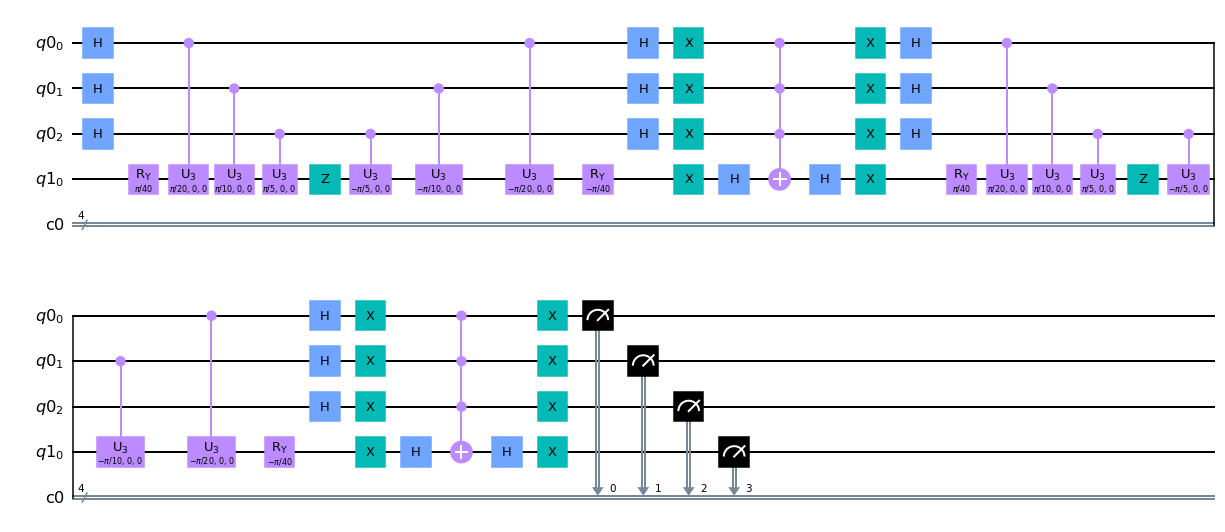

In [6]:
qc_list = create_grover_circuit([2], nbit, b_max, barrier=True)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

We also need a helper function to simultaneously run the quantum circuits that are returned by the above functions, as below. 

In [7]:
def run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=None, seed_transpiler=None, seed_simulator=None):
    """
        Run the quantum circuits returned by create_grover_circuit()
            qc_list: list of quantum circuits
            numebr_grover_list: list of number of Grover operators
            shots_list:  list of number of shots
            backend: name of backends
        
        Return:
            hit_list: list of count of obserbving "1" for qc_list
    """
    counts_list = []
    for k in range(len(number_grover_list)):
        t1 = time.perf_counter()
        # print(k, "th round with", number_grover_list[k], "oracles")
        job = execute(qc_list[k], backend=backend, shots=shots_list[k], noise_model=noise_model, seed_transpiler=seed_transpiler+k, seed_simulator=seed_simulator+k)
        lapse = 0
        interval = 0.00001
        time.sleep(interval)
        while job.status().name != 'DONE':
            time.sleep(interval)
            lapse += 1
        counts_list.append(job.result().get_counts(qc_list[k]))
        t2 = time.perf_counter()
        # print(t2 - t1, "s")
    return counts_list

In [8]:
def make_hit_list(counts_list):
    hit_list = []
    strlen = len(list(counts_list[0].keys())[0])
    for k in range(len(counts_list)):
        hits = counts_list[k].get("0"*strlen, 0)
        hit_list.append(hits)
    return hit_list

### Post processing to estimate the amplitude from results of various Grover Circuits

At the heart of the techniques to estimate the amplitude without QFT and controlled Grover operators is a post processing function that combines the results of running Grover circuits with various number of iterations. Suppose we run Grover operators for $\{m_0, m_1, \ldots, m_M\}$ times and for each of the $m_k$ run, we repeat it for $N_k$ times (i.e., the number of shots) of which we observe $h_k$ times of "good" states. Because the probability of observing "good" states is $\sin^2((2m_k + 1)\theta_a)$, the likelihood of observing $h_k$ times of "good" states is 
$$
L_k(h_k;\theta_a) = \left( \sin^2((2m_k)\theta_a) \right)^{N_k - h_k} \left( \cos^2((2m_k)\theta_a) \right)^{h_k}. 
$$

When we have observation of good states as $\mathbf{h} = \{h_0, h_1, \ldots, h_M\}$, the likelihood function becomes
$$
L(\mathbf{h};\theta_a) = \prod_{k=0}^M L_k(h_k;\theta_a). 
$$

From this, we can find an optimal value of $\tilde{\theta}_a$  that maximizes the above likelihood function, namely, 
$$
\tilde{\theta}_a = \mbox{arg}~\mbox{max}_{\theta} L(\mathbf{h};\theta_a).
$$


The function below is to compute such an optimal $\tilde{\theta}_a$. 

In [9]:
def calculate_theta(hit_list, number_grover_list, shots_list):
    """
        calculate optimal theta values
            hit_list: list of count of obserbving "1" for qc_list
            numebr_grover_list: list of number of Grover operators        
            shots_list: list of number of shots

        Return:
            thetaCandidate_list: list of optimal theta
    """

    small = 1.e-15  # small valued parameter to avoid zero division
    confidenceLevel = 5  # confidence level to determine the search range

    thetaCandidate_list = []
    rangeMin = 0.0 + small
    rangeMax = 0.5 - small
    for igrover in range(len(number_grover_list)):

        def loglikelihood(p):
            ret = np.zeros_like(p)
            theta = np.arcsin(np.sqrt(p))
            for n in range(igrover + 1):
                ihit = hit_list[n]
                arg = (2 * number_grover_list[n]) * theta
                ret = ret + 2 * ihit * np.log(np.abs(np.cos(arg))) \
                          + 2 * (shots_list[n] - ihit) * np.log(np.abs(np.sin(arg)))
            return -ret

        searchRange = (rangeMin, rangeMax)
        searchResult = optimize.brute(loglikelihood, [searchRange], Ns=256)
        pCandidate = searchResult[0]
        thetaCandidate_list.append(np.arcsin(np.sqrt(pCandidate)))
        perror = CalcErrorCramérRao(igrover, shots_list, pCandidate, number_grover_list)
        rangeMax = min(pCandidate+confidenceLevel*perror,0.5 - small)
        rangeMin = max(pCandidate-confidenceLevel*perror,0.0 + small)
    return thetaCandidate_list

### Remark about the Cramér-Rao bound

The advantages offered by Amplitude Amplification without QFT and Controlled Grover operators depend on the design of sequences of number of Grover iterations $\{m_k\}$ and number of shots $\{N_k\}$ for each run of iteration. The Cramér-Rao inequality provides the lower bound of the error of estimating the amplitude by the following

$$
\mbox{var}(\tilde{a}) = \mathbb{E}[(\tilde{a} - \mathbb{E}[\tilde{a}])^2] \ge \frac{\|1 + b'(a)\|^2}{\mathcal{I}(a)},
$$
where $b'(a)$ is the derivative of $b(a) \equiv \mathbb{E}[\tilde{a} - a]$ with respect to $a$, and $\mathcal{I}(a)$ is the so-called *Fisher information* defined as 

$$
\mathcal{I}(a) = \mathbb{E}\left[ \left( \frac{\partial \ln{L(x;a)} }{\partial a} \right)^2\right].
$$

With regards to $\{m_k\}$ and $\{N_k\}$, the total number of oracle calls is given as 
$$
N_{\mbox{orac}} = \sum_{k=0}^{M} N_k (2 m_k),
$$
and the Fisher information is given as
$$
\mathcal{I}(a) = \frac{1}{a(1-a)} \sum_{k=0}^{M} N_k(2m_k)^2 \le \frac{1}{a(1-a)} N^2_{\mbox{orac}}.
$$

Thus, the error $\tilde{\epsilon} = \mathbb{E}[(\tilde{a} - a)^2]$ satisfies 
$$
\tilde{\epsilon} \approx \frac{1}{\mathcal{I}(a)^{1/2}} \ge \frac{\sqrt{a(1-a)}}{N_{\mbox{orac}}}
$$

The bound above gives the lower bound of approximation error with regards to the approximated value $a$ and the total number of quantum oracle calls. Note that $\tilde{\epsilon} \approx \sqrt{a(1-a)}N_{\mbox{orac}}^{1/2}$ for classical case, which is quadratically worse than the quantum case. 

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [10]:
#setting the number of shots and Grover operators.

shots = 8192
number_grover_list = [1, 2, 4, 8, 16, 32]  # list of number of Grover operators
shots_list = [shots] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception('The length of shots_list should be equal to the length of number_grover_list.')

backend = Aer.get_backend('qasm_simulator')

We also need functions to evaluate the accuracy against the true value. 

In [11]:
def CalcErrorCramérRao(M, shot_list, p0, number_grover_list):
    """
        calculate Cramér-Rao lower bound
            M: upper limit of the sum in Fisher information 
            shots_list:  list of number of shots
            p0: the true parameter value to be estimated
            numebr_grover_list: list of number of Grover operators        

        Return:
            square root of Cramér-Rao lower bound:  lower bound on the standard deviation of unbiased estimators
    """
    FisherInfo = 0
    for k in range(M + 1):
        Nk = shot_list[k]
        mk = number_grover_list[k]
        FisherInfo += Nk / (p0 * (1 - p0)) * (2 * mk)**2
    return np.sqrt(1 / FisherInfo)


def CalcNumberOracleCalls(M, shots_list, number_grover_list):
    """
        calculate the total number of oracle calls
            M: upper limit of the sum in Fisher information 
            shots_list:  list of number of shots
            numebr_grover_list: list of number of Grover operators        

        Return:
            Norac: the total number of oracle calls
    """
    Norac = 0
    for k in range(M + 1):
        Nk = shots_list[k]
        mk = number_grover_list[k]
        Norac += Nk * (2 * mk)
    return Norac

Finally, we can run the algorithm as below: 

In [12]:
qc_list = create_grover_circuit(number_grover_list, nbit, b_max)  # list of Grover circuits
hit_list = run_grover(qc_list, number_grover_list, shots_list, backend, seed_transpiler=0, seed_simulator=0)  # list of number of grover operators
thetaCandidate_list = calculate_theta(make_hit_list(hit_list), number_grover_list, shots_list)  # list of estimated theta values

We can now plot to find the correlation between the number of oracle calls and the approximation error of $\theta_a$, as well as the lower bound of such error provided by the Cramér-Rao. 

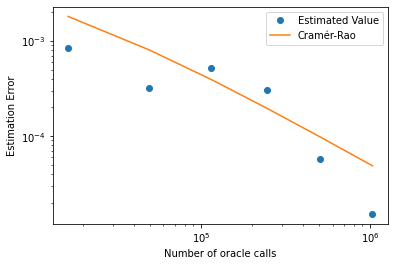

In [13]:
error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

p1 = plt.plot(OracleCall_list, error_list, 'o')
p2 = plt.plot( OracleCall_list, ErrorCramérRao_list)
plt.xscale('log')
plt.xlabel("Number of oracle calls")
plt.yscale('log')
plt.ylabel("Estimation Error")
plt.legend((p1[0], p2[0]), ("Estimated Value", "Cramér-Rao"))
plt.show()

From the above graph, we can see that the estimation error tends to decrease with the increase of the number oracle calls but has deviates from Cramér-Rao lower bound. Because Cramér-Rao lower bound express a bound for statistical mean of estimation errors, we now repeat the above algorithm $n_{trial}=100$ times to estimate the statisitical mean of errors.

In [14]:
n_trial = 20
error_list= np.zeros_like(number_grover_list,dtype=float)
error_list_list = [np.zeros_like(number_grover_list,dtype=float)]
qc_list = create_grover_circuit(number_grover_list, nbit, b_max)
for i in range(n_trial):
    sys.stdout.write("n_trial=(%d/%d)\r" % ((i + 1), n_trial))
    sys.stdout.flush()
    hit_list = run_grover(qc_list, number_grover_list, shots_list, backend, 
                          seed_transpiler=i * len(number_grover_list), seed_simulator=i * len(number_grover_list))
    thetaCandidate_list = calculate_theta(make_hit_list(hit_list), number_grover_list, shots_list)
    error_list += (np.sin(thetaCandidate_list)**2 - discretizedResult)**2  # list of estimation errors
    error_list_list.append(np.sin(thetaCandidate_list)**2 - discretizedResult)
error_list = (error_list / (n_trial-1))**(1/2)

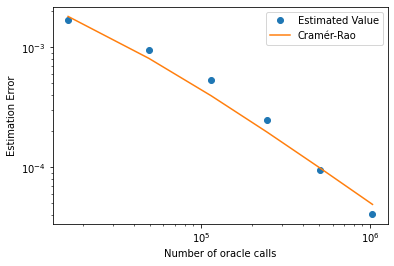

In [16]:
p1 = plt.plot(OracleCall_list, error_list, 'o')
p2 = plt.plot(OracleCall_list, ErrorCramérRao_list)
plt.xscale('log')
plt.xlabel("Number of oracle calls")
plt.yscale('log')
plt.ylabel("Estimation Error")
plt.legend((p1[0], p2[0]), ("Estimated Value", "Cramér-Rao"))
plt.show()

In [17]:
np.array(error_list_list).shape

(21, 6)

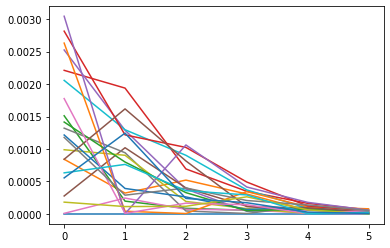

In [18]:
for i in range(len(error_list_list)):
    plt.plot(np.abs(np.array(error_list_list)[i]))

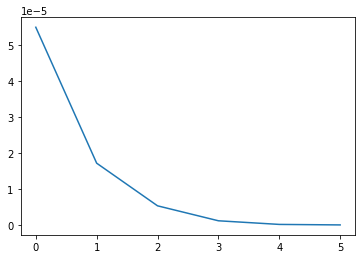

In [19]:
plt.plot( np.sum(np.array(error_list_list) ** 2, axis=0) )

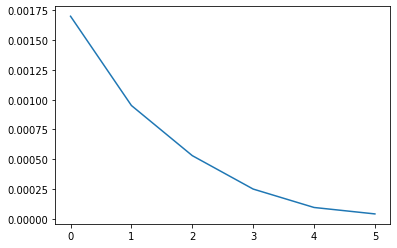

In [20]:
plt.plot( ( np.sum(np.array(error_list_list) ** 2, axis=0) / (n_trial-1) ) ** (1 / 2) )

We can see that the above algorithm achieved almost as good as the lower bound provided by the Cramér-Rao bound. 